# Customer Segmentation with Clustering

**Project Objective:** To use unsupervised machine learning to identify distinct groups of customers within a mall's dataset. By segmenting customers based on multiple dimensions (income, age, spending habits).


### Core Concepts:
1.  **Clustering Fundamentals & K-Means:** A deep dive into how the K-Means algorithm works.
2.  **The Elbow Method:** A critical technique for finding the optimal number of clusters (`k`).
3.  **Multi-dimensional EDA:** Exploring relationships between all features using 2D and 3D plots.
4.  **Multiple Segmentation Models:** Building and interpreting different clustering models based on different feature sets.
5.  **Hierarchical Clustering:** A brief introduction to an alternative clustering method.
6.  **Data-Driven Personas:** Translating cluster statistics into actionable business strategies.

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

os.environ["OMP_NUM_THREADS"] = "1" # Fixes KMeans on Windows (read for more info)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_style('whitegrid')

In [29]:
df = pd.read_csv('data/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### In-Depth Exploratory Data Analysis (EDA)
Before clustering, we must understand the features and their relationships to find the most promising dimensions for segmentation.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [31]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


#### Univariate Analysis (Feature Distributions)

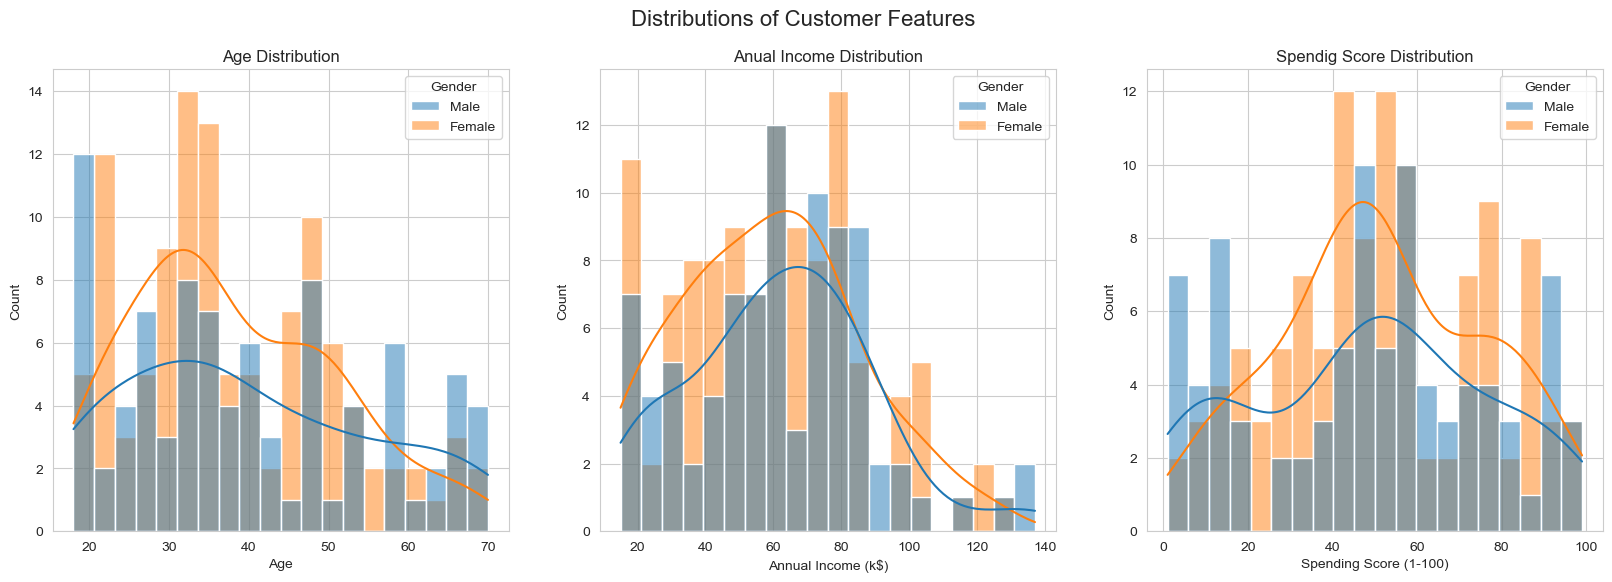

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Distributions of Customer Features", fontsize=16)

sns.histplot(ax=axes[0], data=df, x='Age', kde=True, bins=20, hue='Gender').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=df, x='Annual Income (k$)', kde=True, bins=20, hue='Gender').set_title("Anual Income Distribution")
sns.histplot(ax=axes[2], data=df, x='Spending Score (1-100)', kde=True, bins=20, hue='Gender').set_title("Spendig Score Distribution")

plt.show()

#### Bivariate Analysis (Looking for Relationships)

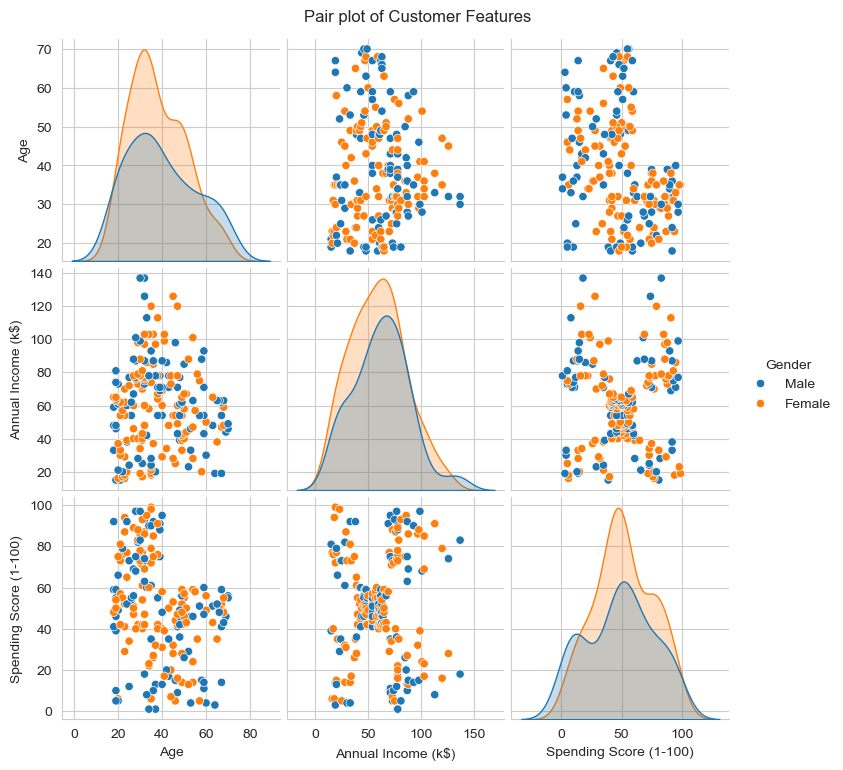

In [33]:
sns.pairplot(data=df, vars=['Age', 'Annual Income (k$)','Spending Score (1-100)'], hue='Gender', diag_kind='kde')
plt.suptitle("Pair plot of Customer Features", y=1.02)
plt.show()

**CRITICAL INSIGHT from Pair Plot:**
- The **`Annual Income` vs. `Spending Score`** plot is the most revealing. It clearly shows distinct, blob-like groups, making it the perfect candidate for clustering.
- The **`Age` vs. `Spending Score`** plot shows some patterns but they are less defined. We see a concentration of high-spending customers in the younger age brackets.
- `Gender` does not appear to be a strong separating factor in any of these plots, as the distributions for males and females largely overlap.

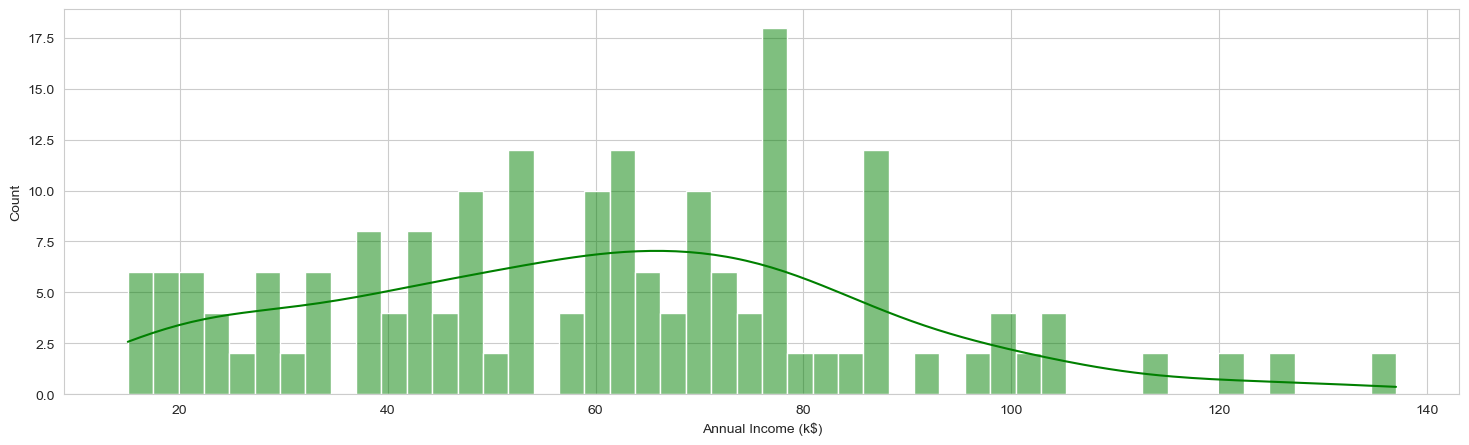

0.3218425498619055


In [ ]:
plt.figure(figsize=(18, 5))
sns.histplot(data=df, x='Annual Income (k$)', kde=True, color='green', bins=50)
plt.show()
print(df['Annual Income (k$)'].skew())

#### 3D Visualization
Let's visualize the three most important features together in an interactive 3D plot to see if the clusters hold up.

In [35]:
fig = px.scatter_3d(df,
                    x='Annual Income (k$)',
                    y='Spending Score (1-100)',
                    z='Age',
                    color='Gender',
                    title='3D View of Customer Data')
fig.show()

### Segmentation Model 1 - Income & Spending Score
This is our primary segmentation model, focusing on the most promising features identified in the EDA.

## **The Elbow Method**

How do we choose the best number of clusters (`k`) for our K-Means model? The **Elbow Method** is a common technique.

It works by calculating the **Within-Cluster Sum of Squares (WCSS)** for different values of `k` (typically from 1 to 10). WCSS is the sum of the squared distances between each point and the centroid of the cluster it belongs to. A lower WCSS means the points are closer to their cluster centroids, indicating tighter clusters.

We then plot WCSS against the number of clusters (`k`). As `k` increases, WCSS will always decrease (because each point gets closer to its assigned centroid). However, at some point, adding more clusters doesn't significantly reduce the WCSS. This point, where the rate of decrease sharply changes, looks like an "elbow" in the plot.

The **optimal number of clusters (`k`)** is typically chosen at this elbow point. It represents a good balance between having too few clusters (high WCSS) and too many clusters (overfitting and diminishing returns).

Here are the most common init options available:

* 'k-means++' (Default): This is the recommended method. It smarty initializes the centroids to be spread out from each other. This significantly improves the chances of finding a globally optimal solution and reduces the risk of converging to a suboptimal local minimum.
* 'random': This method chooses n_clusters observations (data points) randomly from the dataset and uses them as the initial centroids. While simple, it can sometimes lead to poor clustering results if the random initial centroids are not well-separated.
* A NumPy array: You can also provide a NumPy array with a shape of (n_clusters, n_features) that explicitly specifies the initial coordinates of the centroids. This is useful if you have prior knowledge about where the clusters should be located or if you want to replicate a specific initialization.

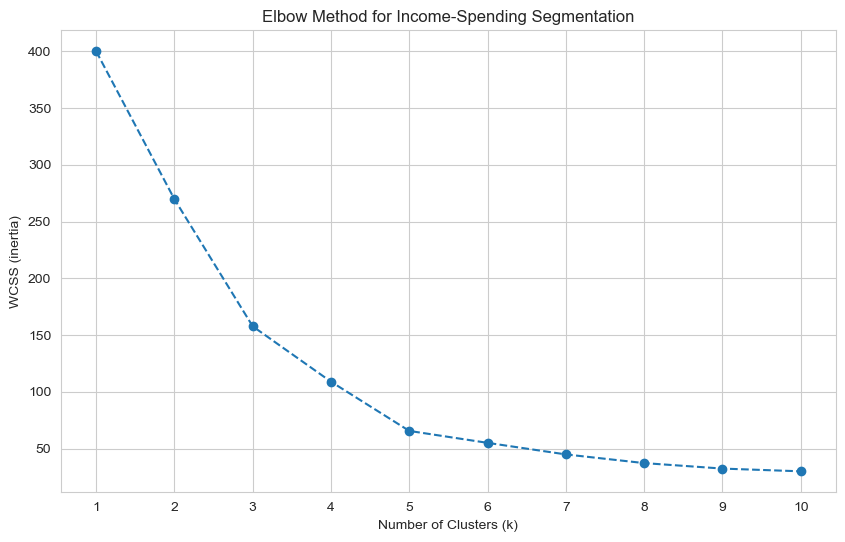

In [38]:
# Select and scale the values (important in clustering, because we are talking about distances here)
X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
  k_means = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
  k_means.fit(X1_scaled)
  wcss1.append(k_means.inertia_)
  
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title("Elbow Method for Income-Spending Segmentation")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (inertia)")
plt.xticks(range(1, 11))
plt.show()

**Observation:** The "elbow" of the curve is clearly at **k=5**. The WCSS decreases sharply until k=5, and then the rate of decrease flattens out. This confirms our visual intuition from the scatter plot!

In [40]:
## Building and fitting the model
k_means = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Income_Cluster'] = k_means.fit_predict(X1_scaled)

In [44]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Income_Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,2
2,3,Female,20,16,6,4
3,4,Female,23,16,77,2
4,5,Female,31,17,40,4
...,...,...,...,...,...,...
195,196,Female,35,120,79,1
196,197,Female,45,126,28,3
197,198,Male,32,126,74,1
198,199,Male,32,137,18,3


#### Visualizing and Interpreting the Income-Based Segments

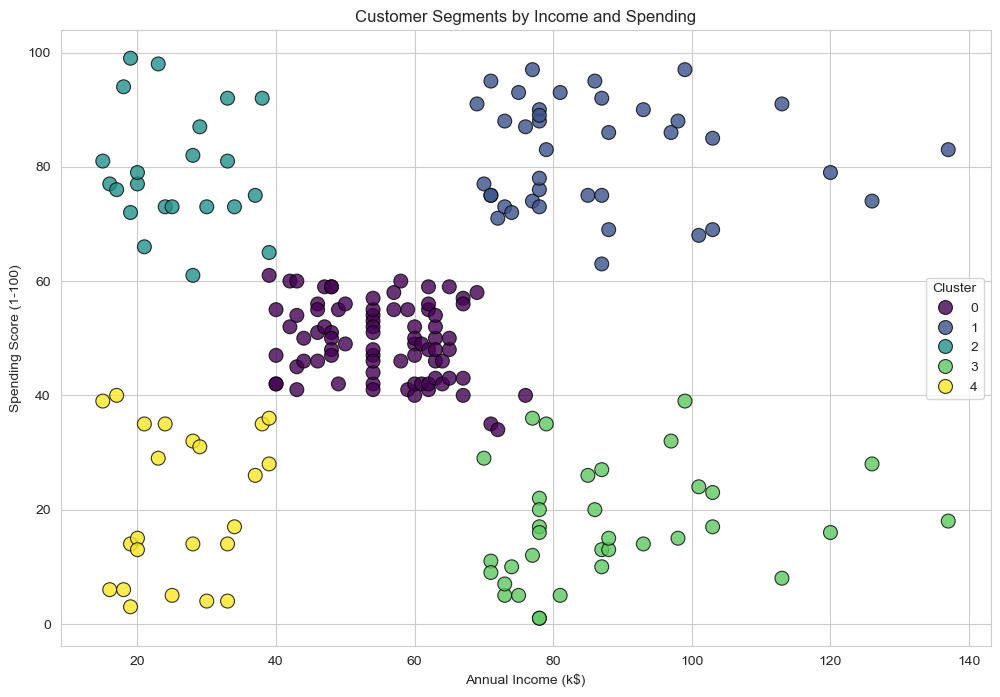

In [42]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title("Customer Segments by Income and Spending")
plt.legend(title="Cluster")
plt.show()

In [46]:
# Quantitative Persona Analysis
cluster_profiles1 = df.groupby('Income_Cluster')[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].mean().round(2)
cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
print("--- Income Cluster Profiles ---")
cluster_profiles1

--- Income Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


#### Income-Based Personas and Strategy
Using the quantitative profiles, we can define our segments: **(There is a mismatch in cluster numbers)**
- **Cluster 0 (Standard):** Average income (~55k) and spending (~50). This is the largest, core customer group.
- **Cluster 1 (Target - High Value):** High income (~87k) and high spending (~82). The mall's prime target.
- **Cluster 2 (Enthusiasts):** Low income (~26k) but high spending (~79). Likely young, trend-focused shoppers.
- **Cluster 3 (Careful High-Earners):** High income (~88k) but low spending (~17). Cautious, value-driven buyers.
- **Cluster 4 (Budget Shoppers):** Low income (~26k) and low spending (~21). Highly price-sensitive.

### Segmentation Model 2 - Age & Spending Score
Let's create a different segmentation model to see if we can find age-related customer groups.

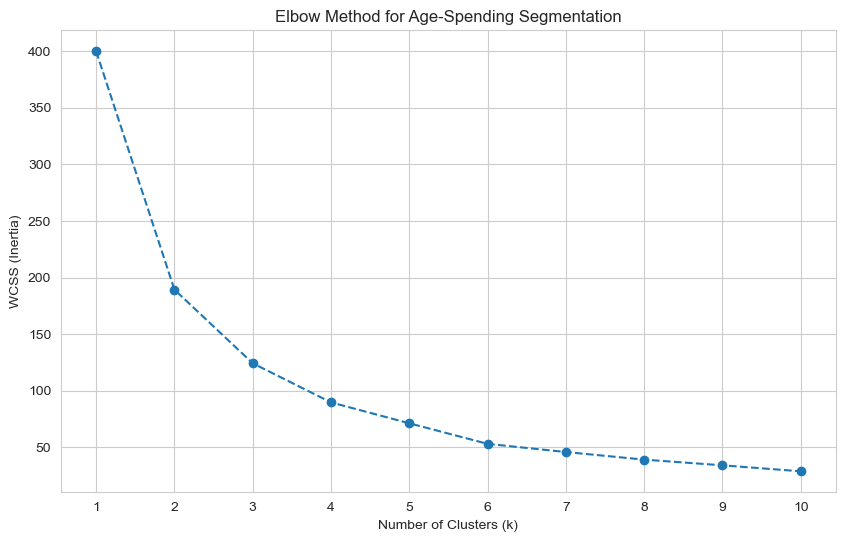

In [47]:
# 1. Select and scale the features
X2 = df[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 2. Implement the Elbow Method
wcss2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    wcss2.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The elbow is less sharp here, but **k=4** appears to be a reasonable choice.

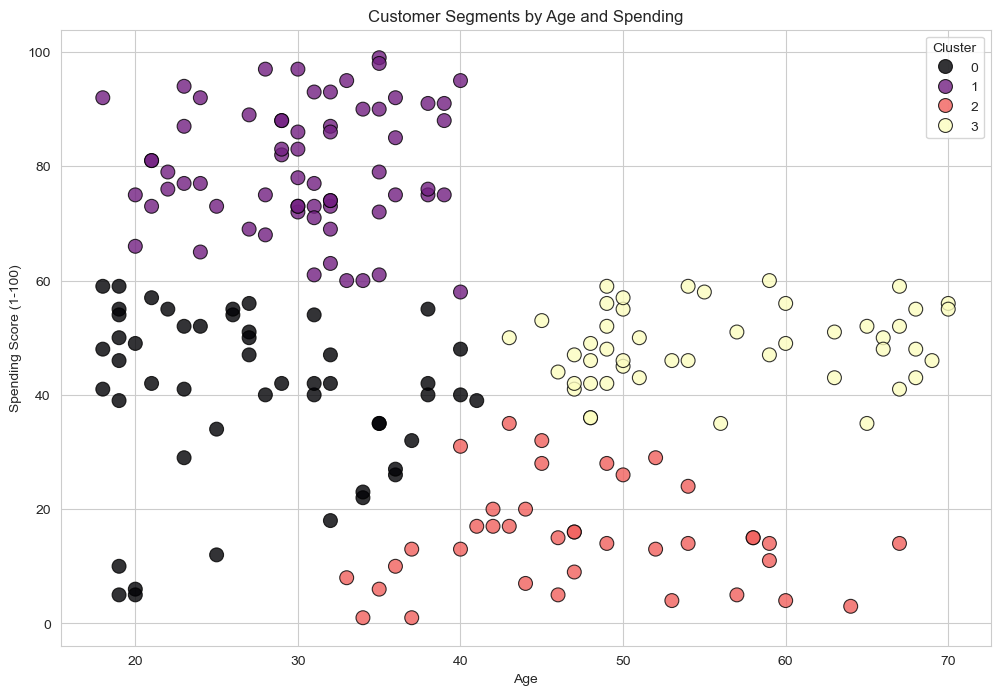

In [48]:
# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending')
plt.legend(title='Cluster')
plt.show()

#### Interpreting the Age-Based Segments
This model gives us a different perspective:
- **Young High-Spenders:** A clear group of customers under 40 with high spending scores.
- **Young Low-Spenders:** Customers under 40 with low-to-moderate spending.
- **Older Average-Spenders:** Customers over 40 with moderate spending scores.
- **Older Low-Spenders:** A small group of older customers with very low spending scores.

### An Alternative Method - Hierarchical Clustering
To add more depth, let's briefly look at another clustering technique.

#### **Hierarchical Clustering & Dendrograms**
Unlike K-Means, Hierarchical Clustering doesn't require us to specify the number of clusters beforehand. It builds a tree-like hierarchy of clusters.

We can visualize this hierarchy with a **dendrogram**. The dendrogram shows how clusters are merged (or split). To find the optimal number of clusters, we look for the tallest vertical line that doesn't cross any horizontal lines and draw a horizontal line through it. The number of vertical lines our new line crosses is the optimal number of clusters.


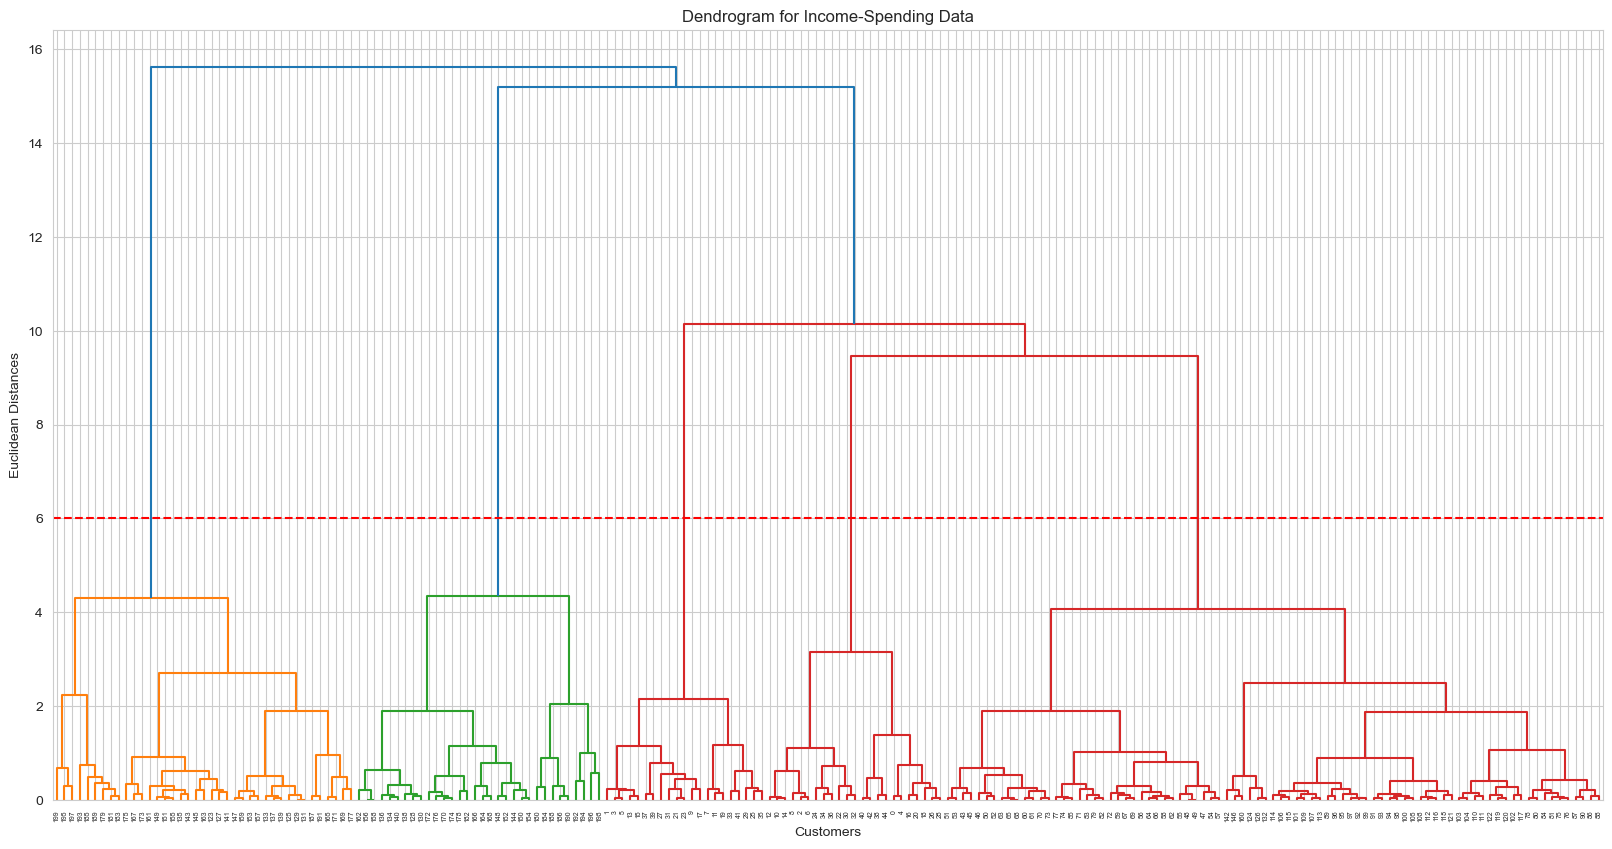

In [49]:
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X1_scaled, method='ward'))
plt.title('Dendrogram for Income-Spending Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=6, color='r', linestyle='--')  # Example cut-off line
plt.show()

**Insight:** The dendrogram also confirms that **5 clusters** is the optimal number for the income-spending data. If we draw a horizontal line at a height of 6 (as shown by the red dashed line), it crosses five vertical lines.

### Conclusion

**Key Steps Undertaken:**
1.  **Performed an in-depth EDA:** Used 2D and 3D plots to explore customer data from multiple angles.
2.  **Built two distinct segmentation models:** Created an income-based model and an age-based model, showing that segmentation is not a one-size-fits-all process.
3.  **Used the Elbow Method** to programmatically determine the optimal number of clusters for each scenario.
4.  **Introduced Hierarchical Clustering** as an alternative method and used its dendrogram to validate our choice of `k`.
5.  **Created quantitative, data-driven personas** for each segment, providing the marketing team with precise, actionable insights for targeted campaigns.
